In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the dataset
# Using the heart_disease.csv file as requested
try:
    data = pd.read_csv('heart_disease.csv')
except FileNotFoundError:
    print("Please make sure 'heart_disease.csv' is in the same directory.")
    exit()

# Display the first few rows to understand the data
print("Initial Data Snapshot:")
print(data.head())
print("\n")

Initial Data Snapshot:
   age   sex               cp  trestbps  chol    fbs         restecg  thalch  \
0   63  Male   typical angina       145   233   True  lv hypertrophy     150   
1   41  Male  atypical angina       135   203  False          normal     132   
2   57  Male     asymptomatic       140   192  False          normal     148   
3   52  Male   typical angina       118   186  False  lv hypertrophy     190   
4   57  Male     asymptomatic       110   201  False          normal     126   

   exang  oldpeak        slope          thal  num  
0  FALSE      2.3  downsloping  fixed defect    0  
1  FALSE      0.0         flat  fixed defect    0  
2  FALSE      0.4         flat  fixed defect    0  
3  FALSE      0.0         flat  fixed defect    0  
4   TRUE      1.5         flat  fixed defect    0  




In [5]:
# Check data types and for missing values
print("Data Info:")
print(data.info())

# Count unique values in categorical columns
for column in ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'num']:
    print(f"\nUnique values in '{column}':")
    print(data[column].value_counts())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       908 non-null    int64  
 1   sex       908 non-null    object 
 2   cp        908 non-null    object 
 3   trestbps  908 non-null    int64  
 4   chol      908 non-null    int64  
 5   fbs       908 non-null    bool   
 6   restecg   908 non-null    object 
 7   thalch    908 non-null    int64  
 8   exang     908 non-null    object 
 9   oldpeak   846 non-null    float64
 10  slope     908 non-null    object 
 11  thal      908 non-null    object 
 12  num       908 non-null    int64  
dtypes: bool(1), float64(1), int64(5), object(6)
memory usage: 86.1+ KB
None

Unique values in 'sex':
sex
Male      718
Female    190
Name: count, dtype: int64

Unique values in 'cp':
cp
asymptomatic       495
non-anginal        203
atypical angina    165
typical angina      45
Name: count, dtype: 

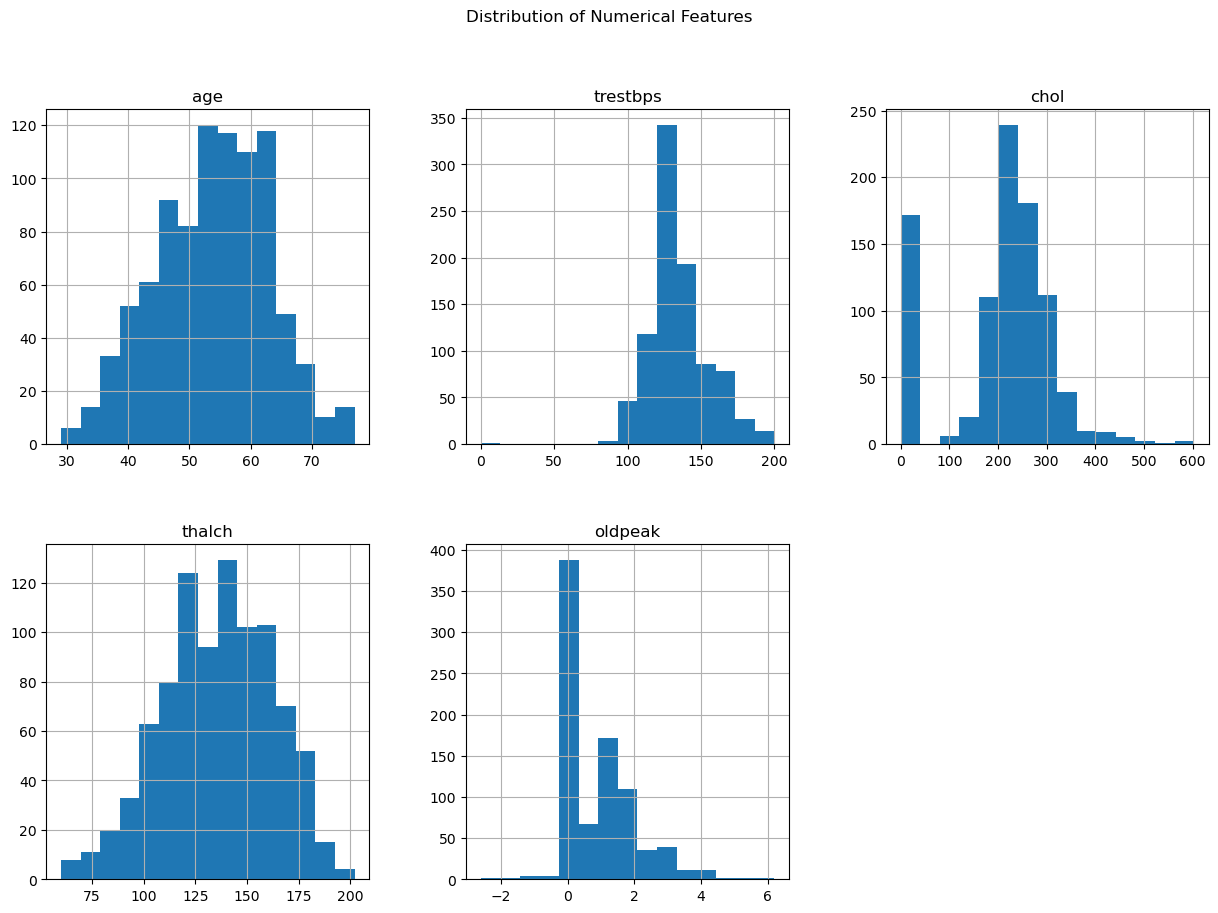

In [6]:
# Visualize the distribution of numerical features
numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
data[numerical_features].hist(bins=15, figsize=(15, 10), layout=(2, 3))
plt.suptitle('Distribution of Numerical Features')
plt.show()

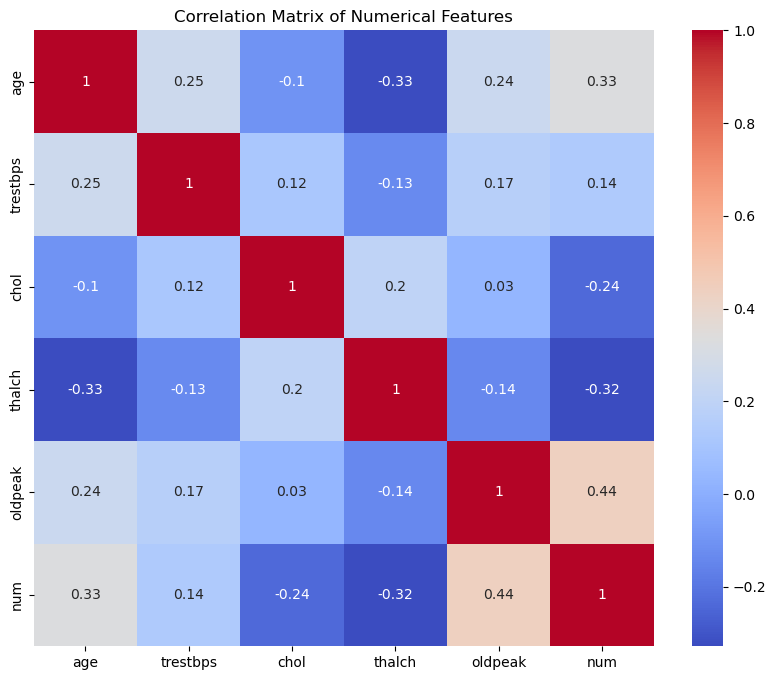

In [7]:
# Create a correlation matrix for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(data[numerical_features + ['num']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [8]:
# The 'chol' column has some zero values, which are biologically impossible.
# The 'trestbps' and 'thalch' also have some zero values.
# The 'oldpeak' column has some missing values (NaN) indicated by empty cells in the CSV.
print(f"\nNumber of zero values in 'trestbps': {data[data['trestbps'] == 0].shape[0]}")
print(f"Number of zero values in 'chol': {data[data['chol'] == 0].shape[0]}")
print(f"Number of zero values in 'thalch': {data[data['thalch'] == 0].shape[0]}")
print(f"Missing values in 'oldpeak': {data['oldpeak'].isnull().sum()}")



Number of zero values in 'trestbps': 1
Number of zero values in 'chol': 172
Number of zero values in 'thalch': 0
Missing values in 'oldpeak': 62


In [10]:
# Handle missing values: Replace empty strings in 'oldpeak' with NaN and then with the mean
# Corrected line: assign the result back to the column
data['oldpeak'] = pd.to_numeric(data['oldpeak'], errors='coerce')
data['oldpeak'] = data['oldpeak'].fillna(data['oldpeak'].mean())

# Replace '?' with NaN and then with mode (for categorical)
for column in ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']:
    data[column] = data[column].replace('?', np.nan)
    # Corrected line: assign the result back to the column
    data[column] = data[column].fillna(data[column].mode()[0])

In [11]:
# Convert categorical data into numerical using one-hot encoding
data = pd.get_dummies(data, columns=['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'], drop_first=True)

# Convert the 'num' target variable to binary (0 for no disease, 1 for any disease stage)
data['num'] = data['num'].apply(lambda x: 1 if x > 0 else 0)

# The 'num' column is our target variable
X = data.drop('num', axis=1)
y = data['num']

print("\nData after Feature Engineering:")
print(X.head())
print("\nTarget variable distribution:")
print(y.value_counts())


Data after Feature Engineering:
   age  trestbps  chol  thalch  oldpeak  sex_Male  cp_atypical angina  \
0   63       145   233     150      2.3      True               False   
1   41       135   203     132      0.0      True                True   
2   57       140   192     148      0.4      True               False   
3   52       118   186     190      0.0      True               False   
4   57       110   201     126      1.5      True               False   

   cp_non-anginal  cp_typical angina  fbs_True  restecg_normal  \
0           False               True      True           False   
1           False              False     False            True   
2           False              False     False            True   
3           False               True     False           False   
4           False              False     False            True   

   restecg_st-t abnormality  exang_TRUE  exang_TURE  slope_flat  \
0                     False       False       False       False 

In [12]:
# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Decision Tree Classifier
# Using a max_depth of 3 for initial model to make it easy to visualize
dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=3)

# Train the model
dt_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
print("\nInitial Decision Tree Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate ROC-AUC
y_pred_proba = dt_classifier.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.2f}")


Initial Decision Tree Model Evaluation:
Accuracy: 0.71

Confusion Matrix:
[[65 15]
 [37 65]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.81      0.71        80
           1       0.81      0.64      0.71       102

    accuracy                           0.71       182
   macro avg       0.72      0.72      0.71       182
weighted avg       0.74      0.71      0.71       182


ROC-AUC Score: 0.78


In [13]:
# Define the parameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 7, 8, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}

# Initialize GridSearchCV with the classifier and parameter grid
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("\nHyperparameter Tuning Results:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2f}")

# Get the best model
best_dt_classifier = grid_search.best_estimator_


Hyperparameter Tuning Results:
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 20}
Best Cross-Validation Accuracy: 0.78



Tuned Decision Tree Model Evaluation:
Accuracy: 0.77

Confusion Matrix:
[[55 25]
 [17 85]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72        80
           1       0.77      0.83      0.80       102

    accuracy                           0.77       182
   macro avg       0.77      0.76      0.76       182
weighted avg       0.77      0.77      0.77       182


ROC-AUC Score: 0.81


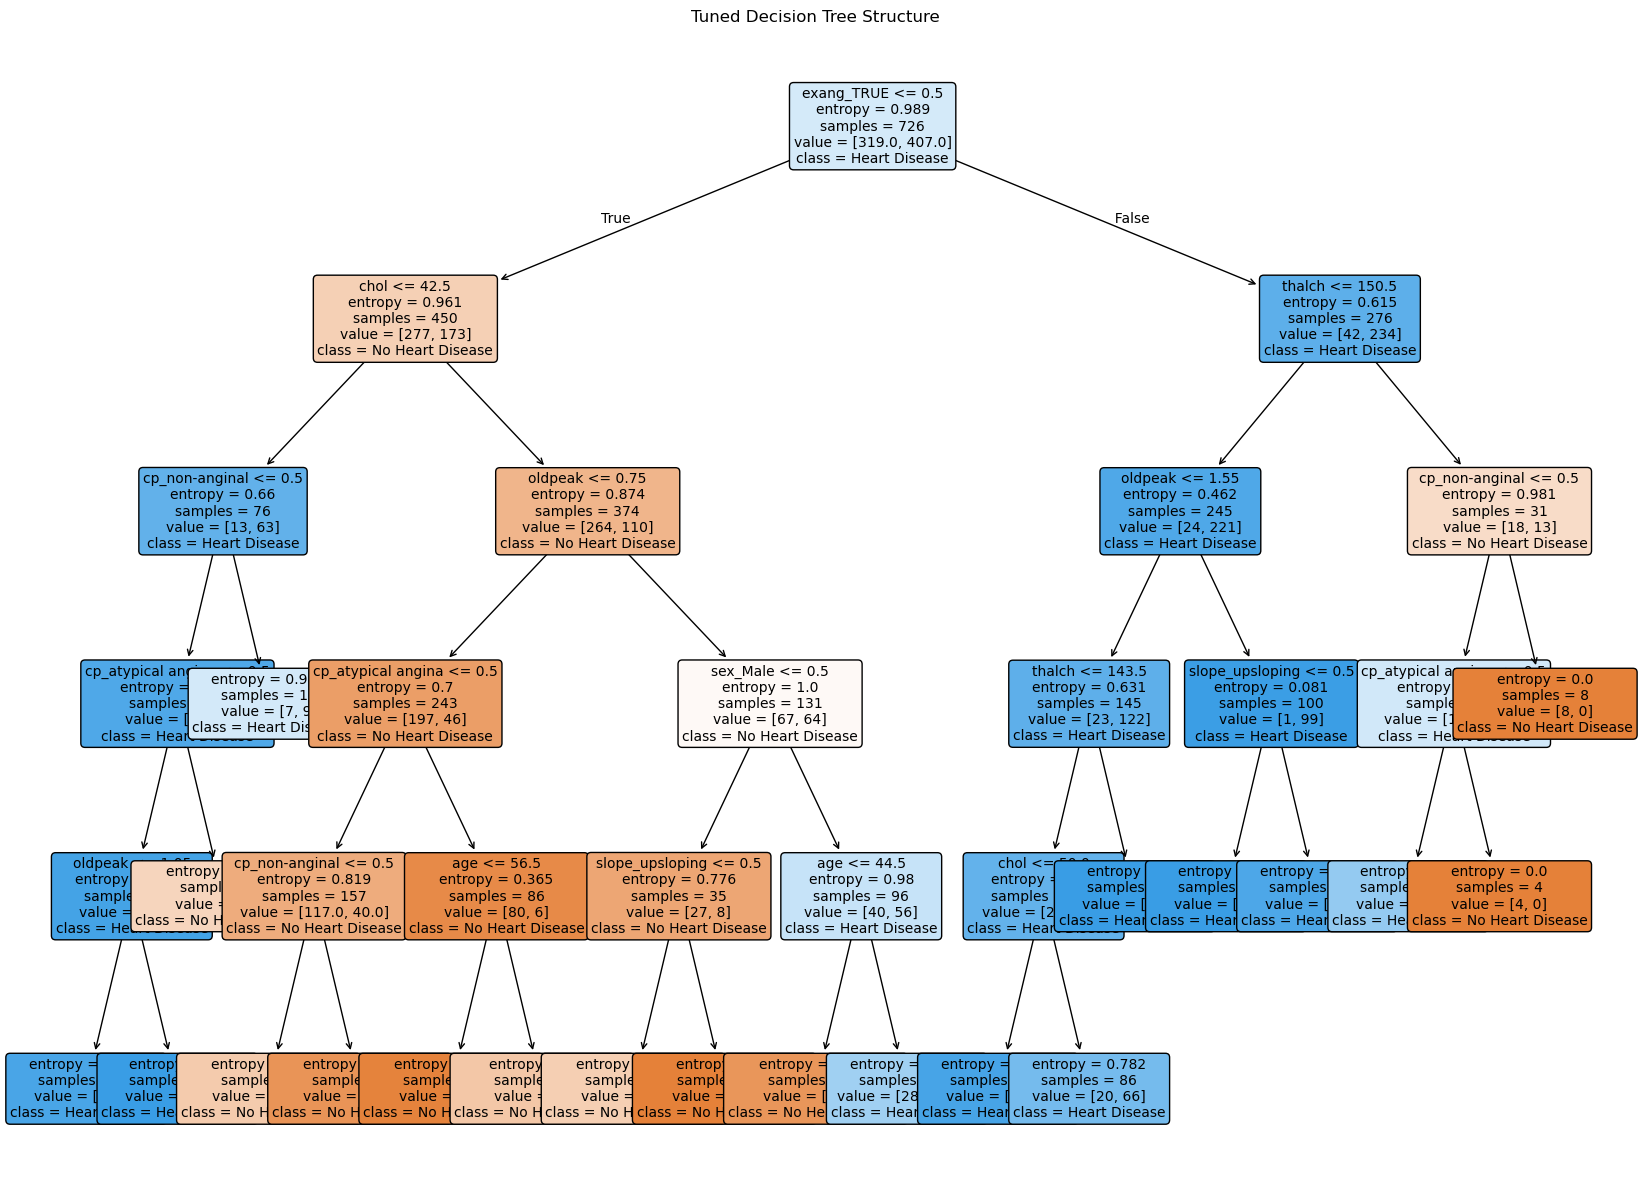


Top 5 Most Important Features:
           feature  importance
12      exang_TRUE    0.348915
2             chol    0.180770
4          oldpeak    0.123630
3           thalch    0.089566
7   cp_non-anginal    0.068395


In [14]:
# Evaluate the tuned model on the test set
y_pred_tuned = best_dt_classifier.predict(X_test)
y_pred_tuned_proba = best_dt_classifier.predict_proba(X_test)[:, 1]

print("\nTuned Decision Tree Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_tuned_proba):.2f}")

# Visualize the decision tree
plt.figure(figsize=(20, 15))
plot_tree(best_dt_classifier,
          feature_names=X.columns.tolist(),
          class_names=['No Heart Disease', 'Heart Disease'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Tuned Decision Tree Structure")
plt.show()

# Get feature importances
importances = pd.DataFrame({'feature': X.columns, 'importance': best_dt_classifier.feature_importances_})
importances = importances.sort_values('importance', ascending=False)
print("\nTop 5 Most Important Features:")
print(importances.head(5))

In [ ]:
'''
1. What are some common hyperparameters of decision tree models, and how do they affect the model's performance?
1. max_depth
Description: This parameter controls the maximum depth or number of levels in the tree. It determines how many decisions the tree can make before 
it must classify a sample.
Effect on Performance:
Low max_depth can lead to underfitting, where the model is too simple to capture the underlying patterns in the data. The model may have high
bias and low variance.
High max_depth can lead to overfitting, where the model becomes too complex and memorizes the training data, including its noise. The model may 
have low bias but high variance, performing poorly on new, unseen data.

2. min_samples_split
Description: This is the minimum number of samples a node must contain to be considered for a split.
Effect on Performance:
A low min_samples_split value (e.g., the default of 2) allows the tree to create more splits, potentially leading to a more complex, overfitted model.
A high min_samples_split value constrains the tree from creating a split if the node doesn't have enough samples, which can help regularize
the model and prevent overfitting.

3. min_samples_leaf
Description: This parameter specifies the minimum number of samples required to be at a leaf node (a terminal node).
Effect on Performance:
A low min_samples_leaf value can create leaf nodes that represent very specific or noisy data points, increasing the risk of overfitting.
A high min_samples_leaf value ensures that each leaf node represents a larger number of samples, making the model more robust and less 
prone to capturing noise.
'''

In [ ]:
'''
2. What is the difference between the Label encoding and One-hot encoding?
Both Label Encoding and One-Hot Encoding are techniques for converting categorical data into a numerical format that machine learning
algorithms can process. The main distinction lies in how they represent the categories.

Label Encoding:-
Assigns a unique integer to each category based on its alphabetical order or appearance.
Ideal for ordinal data, where categories have a meaningful order (e.g., Small, Medium, Large).
It can introduce a false sense of order or a numerical relationship, which can mislead some algorithms 
(like linear regression) into thinking that Green (2) is "more important" or has a higher value than Red (0).

One-Hot Encoding:-
Creates a new binary (0 or 1) column for each unique category.
Perfect for nominal data, where categories have no inherent order (e.g., City, Color).
It can create a large number of new columns, a problem known as the "curse of dimensionality," which can increase
computational cost and memory usage, especially if the categorical feature has many unique values.

'''